In [167]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [7]:
starting_file = ...
df_starting = pd.read_csv(starting_file)
df_starting.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 45 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   City                                                   245 non-null    object 
 1   Current_rate                                           155 non-null    object 
 2   Optimal_rate                                           155 non-null    object 
 3   On_optimal_rate                                        155 non-null    object 
 4   Project_type                                           245 non-null    object 
 5   Installation_date                                      245 non-null    object 
 6   Special_note                                           139 non-null    object 
 7   Comparable_months_count                                155 non-null    float64
 8   Owner_occupied                                    

## Data Cleaning
1. Current_rate values include both HE1 - B and E1 - B. These are equivalent, and need to be standardized into a single value. <br>

In [58]:
focus_columns = ['City', 'Current_rate', 'Optimal_rate', 'On_optimal_rate', 'Project_type', 'Installation_date', 'Comparable_months_count',
                 'Owner_occupied', 'Property_designation', 'Building_sq_ft', 'Bathrooms', 'Bedrooms', 'Stories', 'EV_registered', 'Eff_building_vintage',
                 'Last_ownership_change', 'Pre_elec_avg_mthly_elec_usg', 'Pre_elec_avg_mthly_gas_usg', 'Pre_elec_avg_mthly_totenergy_kwh', 
                 'Pre_elec_avg_mthly_gas_bill', 'Pre_elec_avg_mthly_etoucB_bill', 'Post_elec_avg_mthly_elec_usg', 'Post_elec_avg_mthly_gas_usg',
                 'Post_elec_avg_mthly_totenergy_kwh', 'Post_elec_avg_mthly_gas_bill', 'Post_elec_avg_mthly_etoucB_bill', 
                 'Post_elec_avg_mthly_optimalrate_bill', 'Dollar_change_avg_mthly_etoucB_bill', 'Dollar_change_avg_mthly_gas_bill', 
                 'Dollar_change_avg_mthly_total_bill', 'Dollar_change_etoucB_optimalrate_avg_mthly_total_bill', 'Percent_change_avg_mthly_elec_usg',
                 'Percent_change_avg_mthly_gas_usg', 'Percent_change_avg_mthly_etoucB_total_bill', 'Percent_change_avg_mthly_optimalrate_total_bill']
df_nonas = df_starting.dropna(subset=["Current_rate", "Property_designation"])[focus_columns]
df_nonas['Current_rate'].replace(to_replace={'HE1 - B': 'E1 - B'}, inplace=True)
df_nonas['Installation_date'] = pd.to_datetime(df_nonas['Installation_date'])
df_nonas['Last_ownership_change'] = pd.to_datetime(df_nonas['Last_ownership_change'])
df_nonas.info()


<class 'pandas.core.frame.DataFrame'>
Index: 151 entries, 0 to 244
Data columns (total 35 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   City                                                   151 non-null    object        
 1   Current_rate                                           151 non-null    object        
 2   Optimal_rate                                           151 non-null    object        
 3   On_optimal_rate                                        151 non-null    object        
 4   Project_type                                           151 non-null    object        
 5   Installation_date                                      151 non-null    datetime64[ns]
 6   Comparable_months_count                                151 non-null    float64       
 7   Owner_occupied                                         151 non-null    float

## Considerations of Feature Engineering
A number of dimensions can be extracted from what I've loaded in. <br>

##### Installation_date
From the installation date, I can extract the following: <br>
- Month of installation <br>
- Season (eg. Winter/Summer; or heating/cooling) of installation <br>
- The length of time the equipment has been installed (data was pulled December 2024, so age will be determined as of this date) <br>

##### Last_ownership_change
This is the date of the last recorded transfer of ownership of the property. I can extract the following: <br>
- Ownership_change occured after Installation Date
- Ownership_change occured less than a year before installation date
- Ownership_change occured more than a year before installation date

##### City
From the city, I could assign "zones" based on how we think of the cities: coastal versus inland. This broad categorization may be helpful because it spotlights a factor that will be helpful to evaluate a hypothesis: that coastal households will experience electrification differently due to the regional differences. <br>

##### Eff_building_vintage
Regarding Eff_building_vintage, I am considering condensing the vintage into a categorical variable indicating the decade or range of decades of interest: <br>
- Pre-1930: < January 1, 1930 <br>
- 1930: >= January 1, 1930 and < January 1, 1940 <br>
- 1940: >= January 1, 1940 and < January 1, 1950 <br>
- 1950: >= January 1, 1950 and < January 1, 1960 <br>
- 1960: >= January 1, 1960 and < January 1, 1970 <br>
- 1970: >= January 1, 1970 and < January 1, 1980 <br>
- 1980: >= January 1, 1980 and < January 1, 1990 <br>
- 1990: >= January 1, 1990 and < January 1, 2000 <br>
- Post-2000: >= January 1, 2000 <br>

### From the granular SOBA calculations
I can also go through the more granular dataset that the source data was aggregated from and bulid more features. This would require loading in another CSV with the data and then joining to the working dataset. Deprioritize this until a starting model has been built and evaluated. Potential additional features to consider: <br>
- Summer Average Monthly Usage (Electric, Gas, Combined) <br>
- Winter Average Monthly Usage (Electric, Gas, Combined) <br>
- Number of months with electric or combined usage below a certain threshold <br>

In [68]:
#Extract Month of Installation
df_nonas['Install_month'] = df_nonas['Installation_date'].dt.month

#Assign Season
season_conditions = [df_nonas['Install_month'].isin([1, 2, 3, 4, 11, 12]), #Heating Season
              df_nonas['Install_month'].isin([5, 10]), #Shoulder Months
              df_nonas['Install_month'].isin([6, 7, 8, 9])] #Cooling Season
season_options = ['Heating', 'Shoulder', 'Cooling']
df_nonas['Install_season'] = np.select(season_conditions, season_options)

#Calculate age of equipment
df_nonas['Eqmt_age_months'] = ((df_nonas['Installation_date'].dt.year - 2024) * 12) + (12 - df_nonas['Installation_date'].dt.month)

#Record the recency of ownership change relative to electrification
ownership_conditions = [(df_nonas['Installation_date'] - df_nonas['Last_ownership_change']).dt.days < 365]
ownership_options = ['Less than a year']
df_nonas['Recent_owner_change'] = np.select(ownership_conditions, ownership_options, 'A year or more')

#Assign building vintages to decades
decade_conditions = [df_nonas['Eff_building_vintage'] < 1930,
                     (df_nonas['Eff_building_vintage'] >= 1930) & (df_nonas['Eff_building_vintage'] < 1940),
                     (df_nonas['Eff_building_vintage'] >= 1940) & (df_nonas['Eff_building_vintage'] < 1950),
                     (df_nonas['Eff_building_vintage'] >= 1950) & (df_nonas['Eff_building_vintage'] < 1960),
                     (df_nonas['Eff_building_vintage'] >= 1960) & (df_nonas['Eff_building_vintage'] < 1970),
                     (df_nonas['Eff_building_vintage'] >= 1970) & (df_nonas['Eff_building_vintage'] < 1980),
                     (df_nonas['Eff_building_vintage'] >= 1980) & (df_nonas['Eff_building_vintage'] < 1990),
                     (df_nonas['Eff_building_vintage'] >= 1990) & (df_nonas['Eff_building_vintage'] < 2000),
                     df_nonas['Eff_building_vintage'] >= 2000]
decade_options = ["Pre-1930", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "Post-2000s"]
df_nonas['Decade_built'] = np.select(decade_conditions, decade_options)

In [266]:
#In this instance, "Electrification Success" is defined to be the situation where there is a decrease in the average monthly total bill compared
#to the pre-electrification default case.
df_nonas['Success'] = (df_nonas['Percent_change_avg_mthly_etoucB_total_bill'] < 0) * 1
apriori = ['City', 'Current_rate', 'Project_type', 'Install_month', 'Install_season', 'Recent_owner_change', 'Decade_built',
           'Owner_occupied', 'Property_designation', 'Building_sq_ft', 'Bathrooms', 'Bedrooms', 'Stories', 'EV_registered', 
           'Pre_elec_avg_mthly_elec_usg', 'Pre_elec_avg_mthly_gas_usg', 'Success']
#A regression model might be suitable for predicting the magnitude of savings. In this approach, I'd be interested in seeing what factors contribute,
#even if they include properties that aren't typically known until after the installation. 
#Even though variables like post-electrification energy usage change aren't known until post-intervention, they can be estimated pre-intervention.
df_regression = df_nonas.copy()

#A simpler model will be a classification model that predicts whether or not a customer's electrification project will succeed based on properties
#known a priori. 
df_classification = df_nonas[apriori].copy()


## Classification Model

### The following columns will need to be one-hot encoded:
- City
- Current_rate
- Project_type
- Install_month
- Install_season
- Owner_occupied (binary)
- Property_designation
- EV_registered (binary)
- Recent_owner_change

### The following columns will need to be ordinally encoded:
- Decade_built

### The following fields will need to be scaled for linear regression but not for DecisionTrees:
- Building_sq_ft
- Bathrooms
- Bedrooms
- Stories
- Pre_elec_avg_mthly_elec_usg
- Pre_elec_avg_mthly_gas_usg
- Pre_elec_avg_mthly_totenergy_kwh
- Pre_elec_avg_mthly_gas_bill
- Pre_elec_avg_mthly_etoucB_bill

### Other notes on Classification Model
I want to take advantage of ensemble methods because I have a small sample size. 

In [269]:
#Train-test split
classification_features = df_classification.drop(columns=['Success'])
classification_target = df_classification['Success']
X_train, X_test, y_train, y_test = train_test_split(classification_features, classification_target, test_size=0.2)

## Sequence of Model Training

### Bagging
Start with RandomForestClassifier to get a rough idea of relationships. Then

### AdaBoost
With some directional understanding of the influence of different features on the predictive variable, begin training an AdaBoost model with hyperparameter tuning using GridSearchCV.

In [272]:
#Create Pipeline
onehot_cols = ['City', 'Current_rate', 'Project_type', 'Install_month', 'Install_season', 'Owner_occupied', 'Property_designation', 'EV_registered',
              'Recent_owner_change']
ordinal_cols = ['Decade_built']
classification_encoding = ColumnTransformer(transformers=
    [('OneHot', OneHotEncoder(handle_unknown='ignore'), onehot_cols),
    ('Ordinal', OrdinalEncoder(categories=[decade_options]), ordinal_cols)
    ], remainder='passthrough')
classification_pipeline = Pipeline(steps=[
    ('Encoding', classification_encoding),
    ('Bagging', RandomForestClassifier(oob_score=True, max_features=0.5, max_samples=0.3))]
                                  )
#Fit pipeline
classification_pipeline.fit(X_train, y_train)

#Generate Predictions
train_preds = classification_pipeline.predict(X_train)
test_preds = classification_pipeline.predict(X_test)

In [274]:
#Evaluate accuracy
accuracy_tobeat = max(df_classification['Success'].value_counts())/len(df_classification['Success'])
print(accuracy_tobeat)

print(mean_squared_error(y_test, test_preds)) #Mean Squared Error of Test Set
print(mean_squared_error(y_train, train_preds)) #Mean Squared Error of Train Set

0.5827814569536424
0.3548387096774194
0.125


Text(0.5, 1.0, 'Training Set Confusion Matrix')

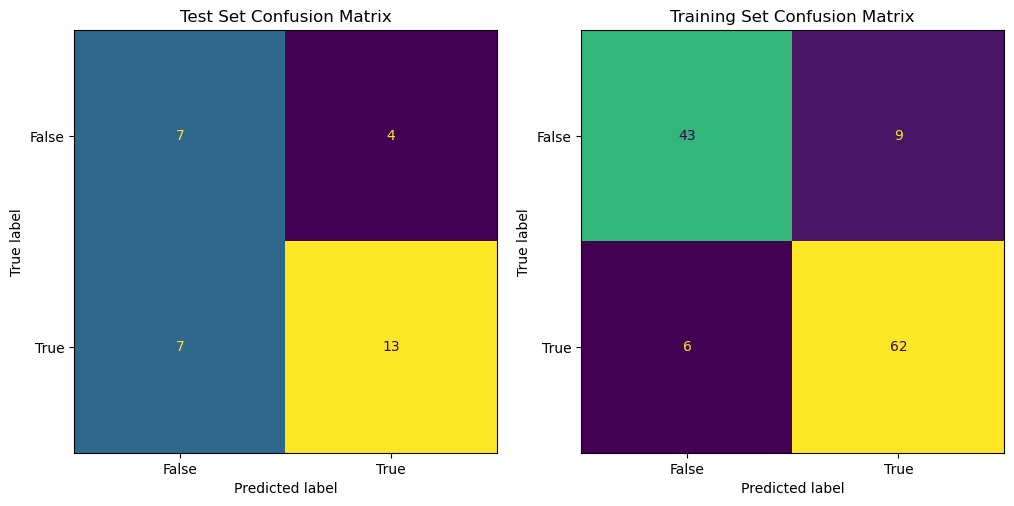

In [276]:
#Generate Confusion Matrices
test_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, test_preds), display_labels=(np.unique(y_test)==1))
train_cm = ConfusionMatrixDisplay(confusion_matrix(y_train, train_preds), display_labels=(np.unique(y_train)==1))

fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.axes[0] = test_cm.plot(ax=axes[0], colorbar=False)
fig.axes[0].set_title('Test Set Confusion Matrix')
fig.axes[1] = train_cm.plot(ax=axes[1], colorbar=False)
fig.axes[1].set_title('Training Set Confusion Matrix')


In [278]:
#Extract parameters for interpretation

df_features = pd.DataFrame(data={'Features': classification_pipeline.named_steps['Encoding'].get_feature_names_out(), 
                                 'Importance': classification_pipeline.named_steps['Bagging'].feature_importances_})
display(df_features.sort_values(by='Importance', ascending=False, ignore_index=True)[0:10])

,Features,Importance
0,remainder__Pre_elec_avg_mthly_gas_usg,0.218000
1,remainder__Pre_elec_avg_mthly_elec_usg,0.120989
2,remainder__Building_sq_ft,0.116367
3,Ordinal__Decade_built,0.056710
4,OneHot__Project_type_HPWH ONLY,0.026993
5,OneHot__Current_rate_HETOUC - B,0.023661
6,remainder__Bathrooms,0.023616
7,OneHot__Project_type_HP HVAC ONLY,0.023563
8,OneHot__Current_rate_HEV2A - B,0.023421
9,remainder__Bedrooms,0.023362


## Classification Model First Pass Evaluation

The baseline predictive accuracy is based on the method of assuming that all electrification projects will succeed or will fail, depending on which one is the most frequently observed. This accuracy is ~58%. <br>

When the model is applied to the test set, the mean squared error is ~35%, which means that the model is roughly 65% accurate. When compared to the mean squared error for the training set, it seems unlikely that the model is overfit: as should be expected, the error on the training set is much lower (13%) but still reasonable. <br>

It would be interesting to see if I can use hyperparameter tuning to improve the accuracy of the model and while minimizing the likelihood of overfitting.

In [299]:
#Hyperparamter tuning
params_randomforest = {
    'Bagging__n_estimators': [10, 50, 100, 500, 1000],
    'Bagging__max_features': np.linspace(0.1, 1, 9),
    'Bagging__max_samples': np.linspace(0.1, 1, 9)
}
class_cv_pipeline = Pipeline(steps=[
    ('Encoding', classification_encoding),
    ('Bagging', RandomForestClassifier())]
                            )
tuning_randomforest = GridSearchCV(class_cv_pipeline, params_randomforest, cv=5)
tuning_randomforest.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Encoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('OneHot',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['City',
                                                                          'Current_rate',
                                                                          'Project_type',
                                                                          'Install_month',
                                                                          'Install_season',
                                                                          'Owner_occupied',
                                                                          'Property_designation',
                                                                          'EV_registered',
                                                                          'Recent_owner_change']),
                                                                        ('Ordinal',
                                                                         OrdinalEncoder(categories=[...
                                                                                                     '1940s',
                                                                                                     '1950s',
                                                                                                     '1960s',
                                                                                                     '1970s',
                                                                                                     '1980s',
                                                                                                     '1990s',
                                                                                                     'Post-2000s']]),
                                                                         ['Decade_built'])])),
                                       ('Bagging', RandomForestClassifier())]),
             param_grid={'Bagging__max_features': array([0.1   , 0.2125, 0.325 , 0.4375, 0.55  , 0.6625, 0.775 , 0.8875,
       1.    ]),
                         'Bagging__max_samples': array([0.1   , 0.2125, 0.325 , 0.4375, 0.55  , 0.6625, 0.775 , 0.8875,
       1.    ]),
                         'Bagging__n_estimators': [10, 50, 100, 500, 1000]})

0.5827814569536424
0.2903225806451613
0.175


Text(0.5, 1.0, 'Training Set (Cross Validation) Confusion Matrix')

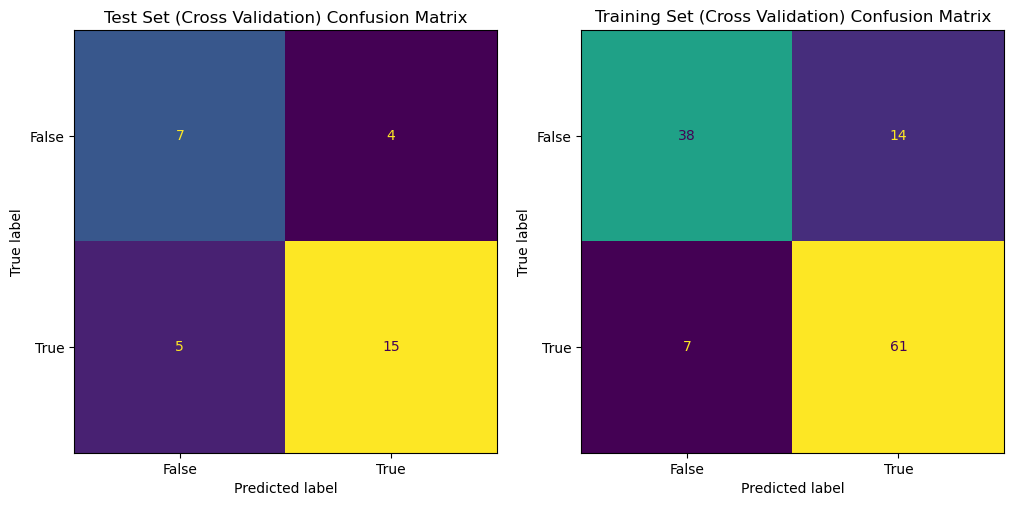

In [300]:
#Evaluate accuracy
cv_train_preds = tuning_randomforest.predict(X_train)
cv_test_preds = tuning_randomforest.predict(X_test)

accuracy_tobeat = max(df_classification['Success'].value_counts())/len(df_classification['Success'])
print(accuracy_tobeat)

print(mean_squared_error(y_test, cv_test_preds)) #Mean Squared Error of Test Set
print(mean_squared_error(y_train, cv_train_preds)) #Mean Squared Error of Train Set

#Generate Confusion Matrices
cvtest_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, cv_test_preds), display_labels=(np.unique(y_test)==1))
cvtrain_cm = ConfusionMatrixDisplay(confusion_matrix(y_train, cv_train_preds), display_labels=(np.unique(y_train)==1))

fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.axes[0] = cvtest_cm.plot(ax=axes[0], colorbar=False)
fig.axes[0].set_title('Test Set (Cross Validation) Confusion Matrix')
fig.axes[1] = cvtrain_cm.plot(ax=axes[1], colorbar=False)
fig.axes[1].set_title('Training Set (Cross Validation) Confusion Matrix')


In [316]:
#Extract parameters for interpretation

df_cv_features = pd.DataFrame(data={'Features': tuning_randomforest.best_estimator_.named_steps['Encoding'].get_feature_names_out(), 
                                 'Importance': tuning_randomforest.best_estimator_.named_steps['Bagging'].feature_importances_})
display(df_features.sort_values(by='Importance', ascending=False, ignore_index=True)[0:10])

,Features,Importance
0,remainder__Pre_elec_avg_mthly_gas_usg,0.218000
1,remainder__Pre_elec_avg_mthly_elec_usg,0.120989
2,remainder__Building_sq_ft,0.116367
3,Ordinal__Decade_built,0.056710
4,OneHot__Project_type_HPWH ONLY,0.026993
5,OneHot__Current_rate_HETOUC - B,0.023661
6,remainder__Bathrooms,0.023616
7,OneHot__Project_type_HP HVAC ONLY,0.023563
8,OneHot__Current_rate_HEV2A - B,0.023421
9,remainder__Bedrooms,0.023362


## Classification using AdaBoost instead of RandomForest



C:\Users\ctang\anaconda3\envs\ProfessionalDev\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


0.41935483870967744
0.06666666666666667


Text(0.5, 1.0, 'Training Set (AdaBoost) Confusion Matrix')

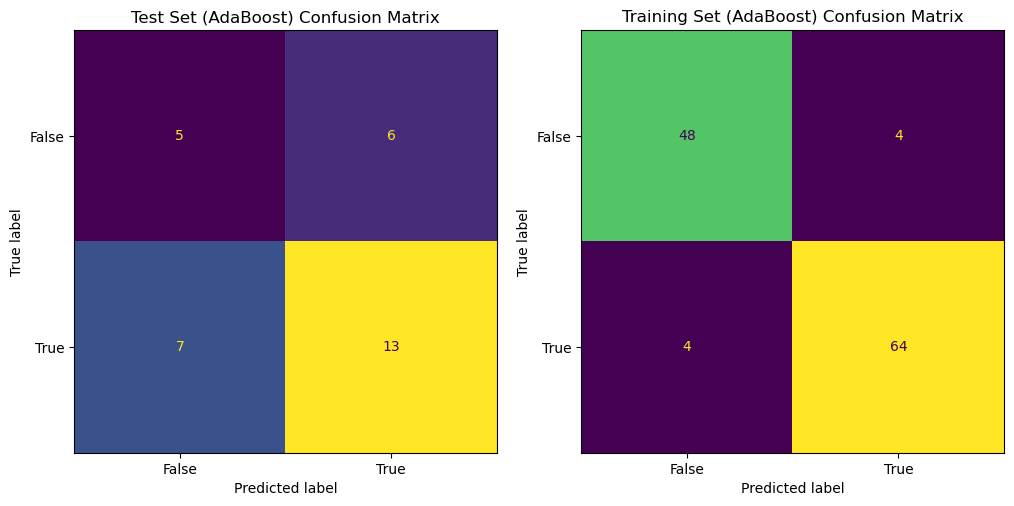

In [306]:
#Create Pipeline using Boosting instead of Bagging, no hyperparameter tuning yet
class_boost_pipeline = Pipeline(steps=[
    ('Encoding', classification_encoding),
    ('Boosting', AdaBoostClassifier())]
                               )
class_boost_pipeline.fit(X_train, y_train)

#Predict
boost_train_preds = class_boost_pipeline.predict(X_train)
boost_test_preds = class_boost_pipeline.predict(X_test)

#Evaluate Accuracy
print(mean_squared_error(y_test, boost_test_preds))
print(mean_squared_error(y_train, boost_train_preds))

#Generate Confusion Matrices
boost_test_cm = ConfusionMatrixDisplay(confusion_matrix(y_test, boost_test_preds), display_labels=(np.unique(y_test)==1))
boost_train_cm = ConfusionMatrixDisplay(confusion_matrix(y_train, boost_train_preds), display_labels=(np.unique(y_train)==1))

fig, axes = plt.subplots(1, 2, figsize=(12,6))
fig.axes[0] = boost_test_cm.plot(ax=axes[0], colorbar=False)
fig.axes[0].set_title('Test Set (AdaBoost) Confusion Matrix')
fig.axes[1] = boost_train_cm.plot(ax=axes[1], colorbar=False)
fig.axes[1].set_title('Training Set (AdaBoost) Confusion Matrix')

## Evaluation of AdaBoosting Approach

The MSE on the test set for the AdaBoostClassifier approach is higher than what was observed for the RandomForestClassifier approach. The MSE for the training set is significantly lower in the AdaBoostClassifier approach than the RandomForestClassifier approach. This suggests the model is overfit. It may be worth doing some hyperparameter tuning on this approach to see if it can be improved.<br>

